In [8]:
import pandas as pd

df = pd.read_csv(r"D:\2025\Time Series\27_5\heart_rate.csv")

df.head()

,T1,T2,T3,T4
0,84.2697,91.4634,60.4839,59.2885
1,84.2697,91.4634,60.4839,59.2885
2,84.0619,91.1834,60.4606,59.2885
3,85.6542,91.8788,60.3391,58.8973
4,87.2093,91.1772,60.0762,58.4359


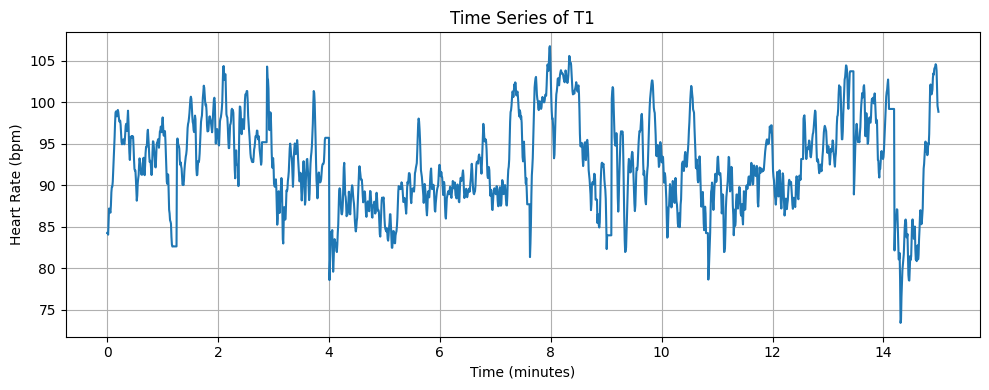

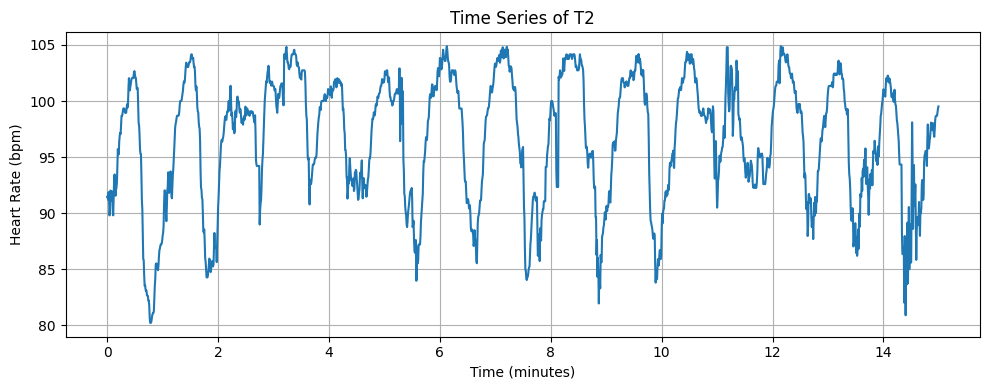

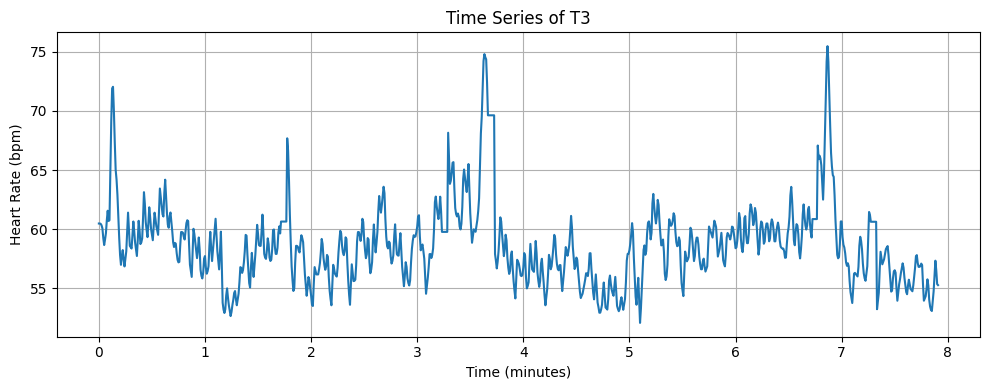

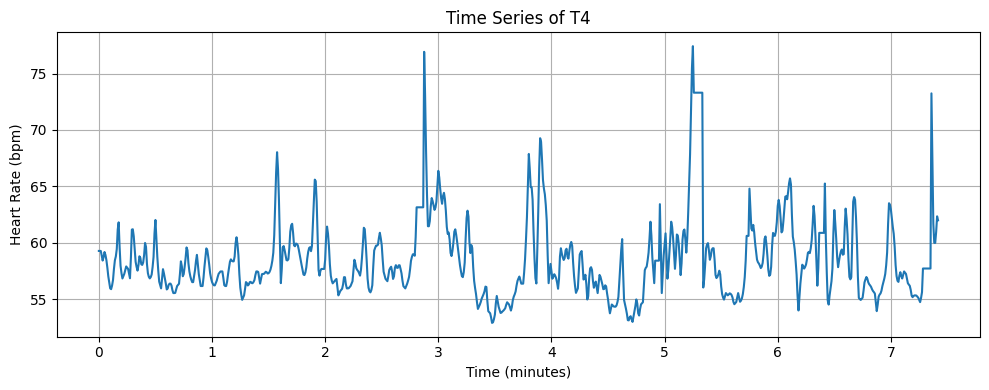

In [9]:
import numpy as np
import matplotlib.pyplot as plt



# Sampling interval and time axis
sampling_interval_sec = 0.5
time_seconds = np.arange(df.shape[0]) * sampling_interval_sec
time_minutes = time_seconds / 60

# Plot each column separately
for column in df.columns:
    series = df[column].dropna().reset_index(drop=True)
    time_axis = np.arange(series.size) * sampling_interval_sec / 60
    
    plt.figure(figsize=(10, 4))
    plt.plot(time_axis, series)
    plt.xlabel('Time (minutes)')
    plt.ylabel('Heart Rate (bpm)')
    plt.title(f'Time Series of {column}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


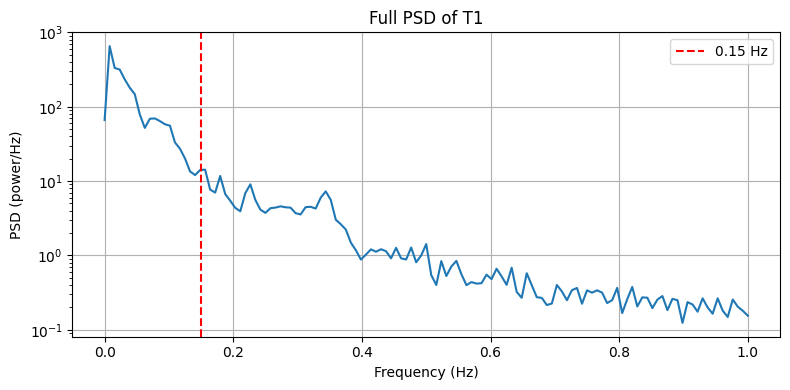

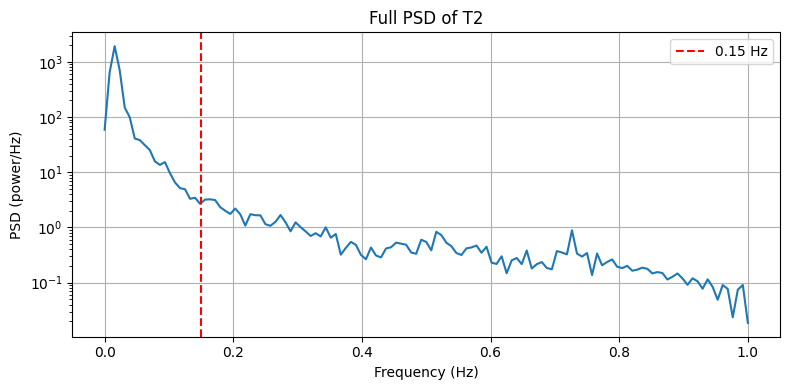

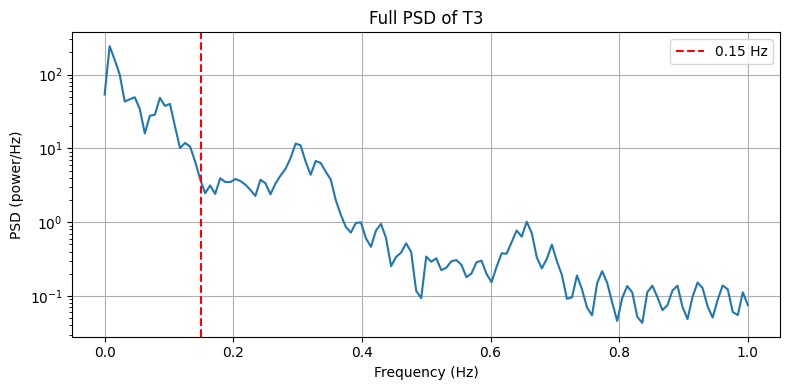

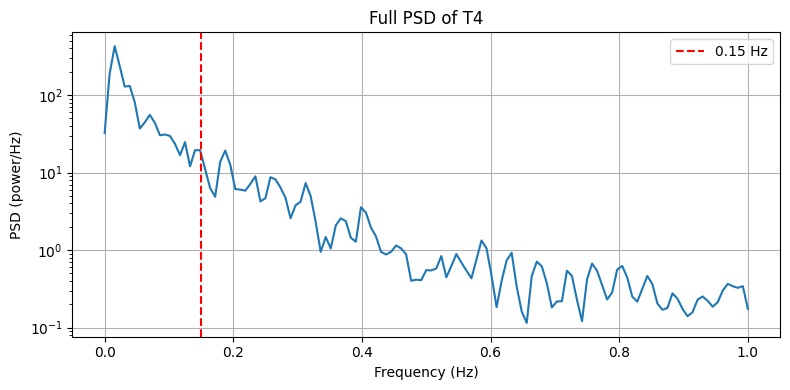

,Series,Window,LF Power,HF Power,HF/LF Ratio
0,T1,Full,4.948804,1.215926,0.245701
1,T1,Seg1,4.915550,1.041752,0.211930
2,T1,Seg2,2.041215,0.834476,0.408814
3,T1,Seg3,8.066666,1.541880,0.191142
4,T1,Seg4,4.458619,1.450245,0.325268
5,T2,Full,1.516956,0.320766,0.211454
6,T2,Seg1,1.804531,0.276054,0.152978
7,T2,Seg2,1.330636,0.248715,0.186915
8,T2,Seg3,1.885997,0.425172,0.225436
9,T2,Seg4,1.878219,0.400203,0.213076


In [10]:
import numpy as np

import matplotlib.pyplot as plt
from scipy.signal import welch



# Frequency analysis parameters
fs = 1 / 0.5  # Sampling frequency (2 Hz)
lfhf_threshold = 0.15  # Hz threshold for LF/HF boundary

results = []

# Function to compute band power
def band_power(freqs, psd, low, high):
    mask = (freqs >= low) & (freqs < high)
    return np.trapz(psd[mask], freqs[mask])

# Analyze each series
for col in df.columns:
    series = df[col].dropna().values
    n = len(series)
    segment_len = n // 4
    
    # PSD for full series
    freqs_full, psd_full = welch(series, fs=fs, nperseg=256)
    
    # Plot full PSD
    plt.figure(figsize=(8, 4))
    plt.semilogy(freqs_full, psd_full)
    plt.axvline(lfhf_threshold, color='r', linestyle='--', label=f'{lfhf_threshold} Hz')
    plt.title(f'Full PSD of {col}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('PSD (power/Hz)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Compute full-series LF/HF powers
    lf_power = band_power(freqs_full, psd_full, 0.04, 0.15)
    hf_power = band_power(freqs_full, psd_full, 0.15, 0.4)
    results.append({
        'Series': col,
        'Window': 'Full',
        'LF Power': lf_power,
        'HF Power': hf_power,
        'HF/LF Ratio': hf_power / lf_power if lf_power else np.nan
    })
    
    # Segment analysis
    for i in range(4):
        seg = series[i*segment_len:(i+1)*segment_len]
        freqs, psd = welch(seg, fs=fs, nperseg=128)
        lf_p = band_power(freqs, psd, 0.04, 0.15)
        hf_p = band_power(freqs, psd, 0.15, 0.4)
        results.append({
            'Series': col,
            'Window': f'Seg{i+1}',
            'LF Power': lf_p,
            'HF Power': hf_p,
            'HF/LF Ratio': hf_p / lf_p if lf_p else np.nan
        })
        
# Display results
results_df = pd.DataFrame(results)
results_df


Series T1:
  Baseline SDNN=0.03, RMSSD=0.01, LF=0.00, HF=0.00
  ALERT at 0.0 min -> Low HF power
  ALERT at 4.0 min -> Low HF power
  ALERT at 5.0 min -> Low HF power

Series T2:
  Baseline SDNN=0.03, RMSSD=0.01, LF=0.00, HF=0.00
  No alerts detected.

Series T3:
  Baseline SDNN=0.06, RMSSD=0.02, LF=0.00, HF=0.00
  No alerts detected.

Series T4:
  Baseline SDNN=0.06, RMSSD=0.02, LF=0.00, HF=0.00
  ALERT at 0.0 min -> Low HF power



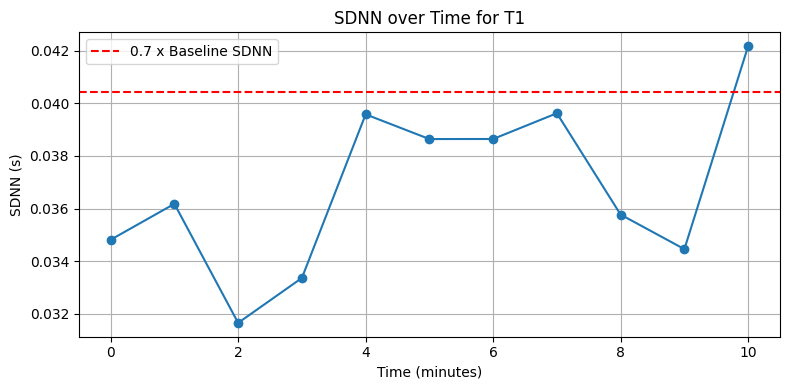

In [20]:
import numpy as np
import pandas as pd
from scipy.signal import welch
import matplotlib.pyplot as plt

# Load data

fs = 2.0  # sampling rate (Hz)

# Convert HR (bpm) to RR intervals (s)
rr_df = 60.0 / df

# Sliding window parameters
window_size = int(5 * 60 * fs)  # 5 minutes
step_size = int(1 * 60 * fs)    # 1 minute

# Baseline calculation: first 3 windows average
features = []
for col in rr_df.columns:
    x = rr_df[col].dropna().values
    
    # compute baseline HRV for first 15 minutes (3 windows)
    hrv_windows = []
    for start in range(0, 3 * step_size, step_size):
        segment = x[start:start + window_size]
        diff = np.diff(segment)
        SDNN = np.std(segment, ddof=1)
        RMSSD = np.sqrt(np.mean(diff**2))
        f, Pxx = welch(segment, fs=fs, nperseg=256)
        LF = np.trapz(Pxx[(f>=0.04)&(f<0.15)], f[(f>=0.04)&(f<0.15)])
        HF = np.trapz(Pxx[(f>=0.15)&(f<0.4)], f[(f>=0.15)&(f<0.4)])
        hrv_windows.append((SDNN, RMSSD, LF, HF))
    
    baseline = np.mean(hrv_windows, axis=0)
    SDNN_baseline, RMSSD_baseline, LF_baseline, HF_baseline = baseline
    
    # Slide through series
    alerts = []
    for start in range(0, len(x) - window_size + 1, step_size):
        segment = x[start:start + window_size]
        diff = np.diff(segment)
        SDNN = np.std(segment, ddof=1)
        RMSSD = np.sqrt(np.mean(diff**2))
        f, Pxx = welch(segment, fs=fs, nperseg=256)
        LF = np.trapz(Pxx[(f>=0.04)&(f<0.15)], f[(f>=0.04)&(f<0.15)])
        HF = np.trapz(Pxx[(f>=0.15)&(f<0.4)], f[(f>=0.15)&(f<0.4)])
        # Arrhythmia detection: >5 RR jumps >20%
        arrhythmia_count = np.sum(np.abs(diff) / segment[:-1] > 0.2)
        # Check conditions
        conditions = []
        if arrhythmia_count > 5:
            conditions.append("Arrhythmia")
        if SDNN < 0.8 * SDNN_baseline:
            conditions.append("Low SDNN")
        if HF < 0.8 * HF_baseline:
            conditions.append("Low HF power")
        if conditions:
            alerts.append((start/fs/60, conditions))
    
    features.append((col, baseline, alerts))

# Display alerts
for col, baseline, alerts in features:
    print(f"Series {col}:")
    print(f"  Baseline SDNN={baseline[0]:.2f}, RMSSD={baseline[1]:.2f}, LF={baseline[2]:.2f}, HF={baseline[3]:.2f}")
    if alerts:
        for t, cond in alerts:
            print(f"  ALERT at {t:.1f} min -> {', '.join(cond)}")
    else:
        print("  No alerts detected.")
    print()

# Example plot: SDNN over time for T1
times = []
sdnns = []
x = rr_df['T1'].dropna().values
for start in range(0, len(x) - window_size + 1, step_size):
    segment = x[start:start + window_size]
    sdnns.append(np.std(segment, ddof=1))
    times.append(start/fs/60)

plt.figure(figsize=(8,4))
plt.plot(times, sdnns, marker='o')
plt.axhline(0.7*baseline[0], color='r', linestyle='--', label='0.7 x Baseline SDNN')
plt.xlabel('Time (minutes)')
plt.ylabel('SDNN (s)')
plt.title('SDNN over Time for T1')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [19]:
# HRV Monitoring Module

import numpy as np
import pandas as pd
from scipy.signal import welch

class HRVMonitor:
    def __init__(self, fs=2.0, window_min=5, step_min=1,
                 rr_jump_thresh=0.2, arrhythmia_count_thresh=5,
                 sdnn_drop=0.7, hf_drop=0.6):
        self.fs = fs
        self.window_size = int(window_min * 60 * fs)
        self.step_size = int(step_min * 60 * fs)
        self.rr_jump_thresh = rr_jump_thresh
        self.arr_th = arrhythmia_count_thresh
        self.sdnn_drop = sdnn_drop
        self.hf_drop = hf_drop

    def _time_domain(self, rr):
        diff = np.diff(rr)
        sdnn = np.std(rr, ddof=1)
        rmssd = np.sqrt(np.mean(diff**2))
        return sdnn, rmssd

    def _freq_domain(self, rr):
        f, Pxx = welch(rr, fs=self.fs, nperseg=min(len(rr), 256))
        lf = np.trapz(Pxx[(f>=0.04)&(f<0.15)], f[(f>=0.04)&(f<0.15)])
        hf = np.trapz(Pxx[(f>=0.15)&(f<0.4)], f[(f>=0.15)&(f<0.4)])
        return lf, hf

    def compute_baseline(self, rr_series):
        b_sdnn, b_hf = [], []
        for start in range(0, 3 * self.step_size, self.step_size):
            seg = rr_series[start:start+self.window_size]
            sdnn, _ = self._time_domain(seg)
            _, hf = self._freq_domain(seg)
            b_sdnn.append(sdnn)
            b_hf.append(hf)
        return np.mean(b_sdnn), np.mean(b_hf)

    def scan(self, rr_series):
        sdnn_base, hf_base = self.compute_baseline(rr_series)
        alerts = []
        for i, start in enumerate(range(0, len(rr_series)-self.window_size+1, self.step_size), 1):
            seg = rr_series[start:start+self.window_size]
            sdnn, _ = self._time_domain(seg)
            lf, hf = self._freq_domain(seg)
            arr_count = np.sum(np.abs(np.diff(seg))/seg[:-1] > self.rr_jump_thresh)

            cond = []
            if arr_count > self.arr_th:
                cond.append("Arrhythmia")
            if sdnn < self.sdnn_drop * sdnn_base:
                cond.append("Low SDNN")
            if hf < self.hf_drop * hf_base:
                cond.append("Low HF")
            if cond:
                alerts.append({
                    'Segment': f'Seg{i}',
                    'Start_min': start/self.fs/60,
                    'SDNN': sdnn,
                    'LF': lf,
                    'HF': hf,
                    'Alerts': '; '.join(cond)
                })
        return pd.DataFrame(alerts)


# Example usage:
if __name__ == "__main__":
    # Load heart rate data
    df = pd.read_csv(r'D:\2025\Time Series\27_5\heart_rate.csv')
    rr_df = 60.0 / df  # convert to RR intervals

    monitor = HRVMonitor()

    # Scan each series T1–T4
    for col in rr_df.columns:
        print(f"\n--- Alerts for {col} ---")
        alerts = monitor.scan(rr_df[col].dropna().values)
        if alerts.empty:
            print("No alerts detected.")
        else:
            print(alerts.to_string(index=False))





--- Alerts for T1 ---
Segment  Start_min     SDNN       LF       HF Alerts
   Seg5        4.0 0.039583 0.000127 0.000035 Low HF
   Seg6        5.0 0.038643 0.000151 0.000029 Low HF

--- Alerts for T2 ---
No alerts detected.

--- Alerts for T3 ---
No alerts detected.

--- Alerts for T4 ---
No alerts detected.
